### **Clone code về từ github**

In [ ]:
!git clone https://github.com/ToanLyHoa/DeepCCA

Cloning into 'DeepCCA'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 27 (delta 4), reused 23 (delta 2), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [ ]:
cd DeepCCA

/content/DeepCCA


### **Chuẩn bị đầy đủ các thư viện**

In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
from linear_cca import linear_cca
from torch.utils.data import BatchSampler, SequentialSampler
from DeepCCAModels import DeepCCA
from main import Solver
from utils import load_data, svm_classify
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle

import gzip
import numpy as np
torch.set_default_tensor_type(torch.DoubleTensor)

### **Tải dữ liệu vào folder DeepCCA**
### **Sau đó load vào data1 và data2**

In [ ]:
!gdown  https://www2.cs.uic.edu/~vnoroozi/noisy-mnist/noisymnist_view1.gz
!gdown  https://www2.cs.uic.edu/~vnoroozi/noisy-mnist/noisymnist_view2.gz
data1 = load_data('noisymnist_view1.gz')
data2 = load_data('noisymnist_view2.gz')

Downloading...
From: https://www2.cs.uic.edu/~vnoroozi/noisy-mnist/noisymnist_view1.gz
To: /content/DeepCCA/noisymnist_view1.gz
100% 88.9M/88.9M [00:01<00:00, 46.0MB/s]
Downloading...
From: https://www2.cs.uic.edu/~vnoroozi/noisy-mnist/noisymnist_view2.gz
To: /content/DeepCCA/noisymnist_view2.gz
100% 210M/210M [00:04<00:00, 50.2MB/s]
loading data ...
loading data ...


### **Set up mọi thứ trước khi train**

In [ ]:
device = torch.device('cuda')
print("Using", torch.cuda.device_count(), "GPUs")

# the path to save the final learned features
save_to = './new_features.gz'

# the size of the new space learned by the model (number of the new features)
outdim_size = 10

# size of the input for view 1 and view 2
input_shape1 = 784
input_shape2 = 784

# number of layers with nodes in each one
layer_sizes1 = [1024, 1024, 1024, outdim_size]
layer_sizes2 = [1024, 1024, 1024, outdim_size]

# the parameters for training the network
learning_rate = 1e-3
epoch_num = 10
batch_size = 800

# the regularization parameter of the network
# seems necessary to avoid the gradient exploding especially when non-saturating activations are used
reg_par = 1e-5

# specifies if all the singular values should get used to calculate the correlation or just the top outdim_size ones
# if one option does not work for a network or dataset, try the other one
use_all_singular_values = False

# if a linear CCA should get applied on the learned features extracted from the networks
# it does not affect the performance on noisy MNIST significantly
apply_linear_cca = True
# end of parameters section
############

Using 1 GPUs


### **Tiến hành train mô hình DeepCCA**

In [ ]:
# Building, training, and producing the new features by DCCA
model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                input_shape2, outdim_size, use_all_singular_values, device=device).double()
l_cca = None
if apply_linear_cca:
    l_cca = linear_cca()
solver = Solver(model, l_cca, outdim_size, epoch_num, batch_size,
                learning_rate, reg_par, device=device)
train1, train2 = data1[0][0], data2[0][0]
val1, val2 = data1[1][0], data2[1][0]
test1, test2 = data1[2][0], data2[2][0]
# val1=None
# test1=None
solver.fit(train1, train2, val1, val2, test1, test2)
# TODO: Save linear_cca model if needed

set_size = [0, train1.size(0), train1.size(
    0) + val1.size(0), train1.size(0) + val1.size(0) + test1.size(0)]
loss, outputs = solver.test(torch.cat([train1, val1, test1], dim=0), torch.cat(
      [train2, val2, test2], dim=0), apply_linear_cca)

[ INFO : 2022-06-23 13:03:12,561 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=784, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (1): Linear(in_features=1024, out_features=10, bias=True)
    

Linear CCA started!


### **Thực hiện train SVM để phân lớp các thuộc tích khi đã qua DeepCCA cho Data1 là dữ liệu không nhiễu**

In [ ]:
new_data = []
# print(outputs)
for idx in range(3):
    new_data.append([outputs[0][set_size[idx]:set_size[idx + 1], :],
                     outputs[1][set_size[idx]:set_size[idx + 1], :], data1[idx][1]])
# Training and testing of SVM with linear kernel on the view 1 with new features
[test_acc, valid_acc, train_acc] = svm_classify(new_data, C=0.01)
print("Accuracy on view 1 (training data) is:", train_acc * 100.0)
print("Accuracy on view 1 (validation data) is:", valid_acc * 100.0)
print("Accuracy on view 1 (test data) is:", test_acc*100.0)

training SVM...
Accuracy on view 1 (training data) is: 97.162
Accuracy on view 1 (validation data) is: 95.48
Accuracy on view 1 (test data) is: 95.45


### **SVM cho data2 dữ liệu nhiễu**

In [ ]:
new_data = []
# print(outputs)
for idx in range(3):
    new_data.append([outputs[1][set_size[idx]:set_size[idx + 1], :],
                     outputs[0][set_size[idx]:set_size[idx + 1], :], data2[idx][1]])
# Training and testing of SVM with linear kernel on the view 1 with new features
[test_acc, valid_acc, train_acc] = svm_classify(new_data, C=0.01)
print("Accuracy on view 2 (training data) is:", train_acc * 100.0)
print("Accuracy on view 2 (validation data) is:", valid_acc * 100.0)
print("Accuracy on view 2 (test data) is:", test_acc*100.0)

training SVM...
Accuracy on view 2 (training data) is: 98.212
Accuracy on view 2 (validation data) is: 92.77
Accuracy on view 2 (test data) is: 92.85


### **Demo kết quả**

[ DEBUG : 2022-06-23 13:05:49,606 ] - Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
[ DEBUG : 2022-06-23 13:05:49,838 ] - Creating converter from 7 to 5
[ DEBUG : 2022-06-23 13:05:49,840 ] - Creating converter from 5 to 7
[ DEBUG : 2022-06-23 13:05:49,845 ] - Creating converter from 7 to 5
[ DEBUG : 2022-06-23 13:05:49,852 ] - Creating converter from 5 to 7
[ INFO : 2022-06-23 13:05:50,677 ] - NumExpr defaulting to 2 threads.
[ DEBUG : 2022-06-23 13:05:50,888 ] - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
[ DEBUG : 2022-06-23 13:05:50,890 ] - findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[ DEBUG : 2022-06-23 13:05:50,894 ] - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
[ DEBUG : 2022-06-23 13:05:50,899 ] - findfont: score(<Font 'STIXSizeT

PREDICTION:  2


[ DEBUG : 2022-06-23 13:05:51,063 ] - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
[ DEBUG : 2022-06-23 13:05:51,065 ] - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
[ DEBUG : 2022-06-23 13:05:51,067 ] - findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2022-06-23 13:05:51,068 ] - findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
[ DEBUG : 2022-06-23 13:05:51,070 ] - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
[ DEBUG : 2022-06-23 13:05:51,071 ] - findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
[ DEBUG : 2022-06-23 13:05:51,073 ] - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
[ DEBUG : 2022-06-23 13:05:51,074 ] - findfont: score(<Font 'cmb10' (cmb10.t

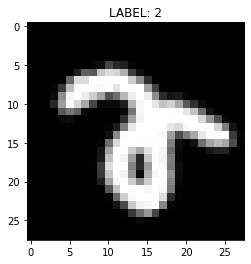

PREDICTION:  1


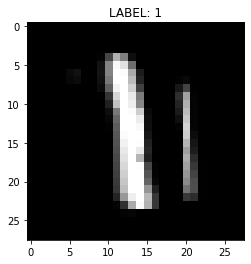

PREDICTION:  0


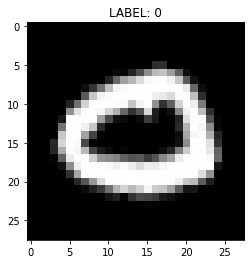

PREDICTION:  1


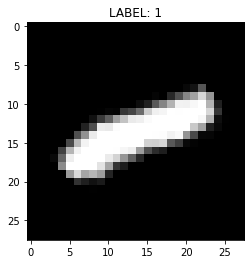

PREDICTION:  0


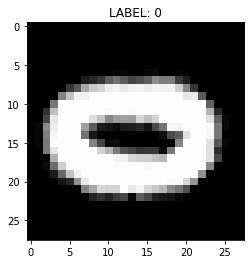

In [ ]:
import matplotlib.pyplot as plt
import keras, random, math
#pick random pictures
num = math.ceil(random.uniform(1,9995))
label = data1[2][1]
for i in range(num, num+5):
    print('PREDICTION: ', label[i])
    plt.title('LABEL: {label}'.format(label=label[i]))
    temp = test1[i].numpy() 
    temp = np.reshape(temp, (28,28), order='F')
    plt.imshow(temp, cmap='gray')
    plt.show()